In [32]:
import os
import csv
import numpy as np
import allan_variance
import matplotlib.pyplot as plt
from tqdm import trange
np.random.seed(0)

In [33]:
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

def csv_write(data, filename):
    filepath = os.getcwd()
    with open(os.path.join(filepath, filename), 'w') as f:
        wh = csv.writer(f, delimiter =' ', quoting=csv.QUOTE_NONE)
        for datum in data:
            wh.writerow(['{:.6f}'.format(x) for x in datum])

In [34]:
def measurement(omega, omega_dot, sf, pos_r, Rb_si, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub)
        omega_i = Rb_si_sub @ omega
        meas[i*6:6+i*6] = np.concatenate((s_i, omega_i))
    return meas

def sim_QN(meas, gyro_range, accel_range, gyro_bits, accel_bits, num_imus):
    quantized_data = np.zeros(6*num_imus)
    quantization_noise = np.zeros(6*num_imus)
    for i in range(num_imus):
        accel_quantization_step = (2 * accel_range) / (2 ** accel_bits)
        gyro_quantization_step  = (2 * gyro_range) / (2 ** gyro_bits)
        quantized_data[i*6:3+i*6]   = np.round(meas[i*6:3+i*6] / accel_quantization_step) * accel_quantization_step # sf
        quantized_data[i*6+3:6+i*6] = np.round(meas[i*6+3:6+i*6] / gyro_quantization_step) * gyro_quantization_step # omega
        quantization_noise[i*6:6+i*6] = quantized_data[i*6:6+i*6] - meas[i*6:6+i*6]

    return quantized_data, quantization_noise

In [ ]:
num_imus = 18
filename = "../data/imu18.txt"

time = np.arange(0, 360, 0.01)
WN_sf = 4.7e-2*np.ones(3)
WN_w =  3.33e-2*np.ones(3)
WN_STD = np.tile(np.concatenate((WN_sf, WN_w)), num_imus)
RW_sf = 1e-4*np.ones(3)
RW_w =  0.0018*np.ones(3)
RW_STD = np.tile(np.concatenate((RW_sf, RW_w)), num_imus)
B         = 3.3e-3
bias_var  = ((2 * B**2)/np.pi) * np.log(2)
gyro_bits = 16  # 16-bit ADC
accel_bits = 16  # 16-bit ADC
accel_range = 16  # Range of accelerometer in g's
gyro_range = 300  # Range of gyroscope in degrees/sec

WN = np.zeros((len(time), 6*num_imus))
RW = np.zeros((len(time), 6*num_imus))
rw = np.zeros((len(time), 6*num_imus))
w_bias = np.zeros((len(time), 6*num_imus))

for i in range(len(time)):
    WN[i,:] = np.random.normal(loc=0, scale=WN_STD, size=6*num_imus)

for i in range(len(time)):
    rw[i,:] = np.random.normal(loc=0, scale=RW_STD, size=6*num_imus)

for i in range(1, len(time)):
    RW[i,:] = RW[i-1,:] + rw[i-1,:]

for i in range(1, len(time)):
    w_bias[i,:] = np.random.normal(0, np.sqrt(bias_var))

In [46]:
dt = 1e-2
angvel_magnitude = 1
Rb_si = [np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), 
         np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3)] # Rotation matrix
pos_r = np.array([[0.0, 0.0, 0.1],
         [0.0, 0.1, 0.0],
         [0.0, 0.0, 0.0], 
         [0.1, 0.0, 0.0],
         [0.0, 0.2, 0.0],
         [0.0, 0.0, 0.2],
         [0.2, 0.0, 0.0],
         [0.0, 0.3, 0.0],
         [0.0, 0.0, 0.3],
         [0.3, 0.0, 0.0],
         [0.0, 0.0, 0.4],
         [0.0, 0.4, 0.0],
         [0.4, 0.0, 0.0],
         [0.0, 0.0, 0.5],
         [0.0, 0.5, 0.0],
         [0.5, 0.0, 0.0],
         [0.0, 0.0, 0.6],
         [0.0, 0.6, 0.0]])

omega = np.array([0, 0, 0])
omega_dot = np.array([0, 0, 0])
sf = np.array([0, 0, 9.8])

state = np.zeros(9)
state[0:3] = omega
state[6:9] = sf
meas_hist = np.zeros((len(time),6*num_imus))
quantized_hist = np.zeros((len(time),6*num_imus))
QN_hist = np.zeros((len(time),6*num_imus))

for i in trange(len(time)):
    meas = measurement(omega, omega_dot, sf, pos_r, Rb_si, num_imus)
    meas_noise = meas + WN[i] + RW[i]
    quantized_data, QN = sim_QN(meas_noise, gyro_range, accel_range, gyro_bits, accel_bits, num_imus)
    meas_hist[i] = meas_noise
    quantized_hist[i] = quantized_data
    # meas_hist[i] = quantized_data
    QN_hist[i] = QN
    
csv_write(meas_hist, filename)

  0%|          | 0/36000 [00:00<?, ?it/s]

100%|██████████| 36000/36000 [00:29<00:00, 1238.26it/s]


In [50]:
axis = ['x', 'y', 'z']

dt = 0.01
    
for i in range(3):
    tau_w, avar_w = allan_variance.compute_avar(meas_hist[:,i+3], dt)
    tau_a, avar_a = allan_variance.compute_avar(meas_hist[:,i], dt)
    params_w, _ = allan_variance.estimate_parameters(tau_w, avar_w)
    params_a, _ = allan_variance.estimate_parameters(tau_a, avar_a)
    print(f"{params_w['white']:0.6f}")
    print(f"{params_w['walk']:0.6f}")
    print(f"{params_a['white']:0.6f}")
    print(f"{params_a['walk']:0.6f}")


0.003272
0.018881
0.004665
0.001025
0.002518
0.015099
0.004400
0.000204
0.002912
0.014843
0.004732
0.000782


Text(0.5, 0, 'Time (s)')

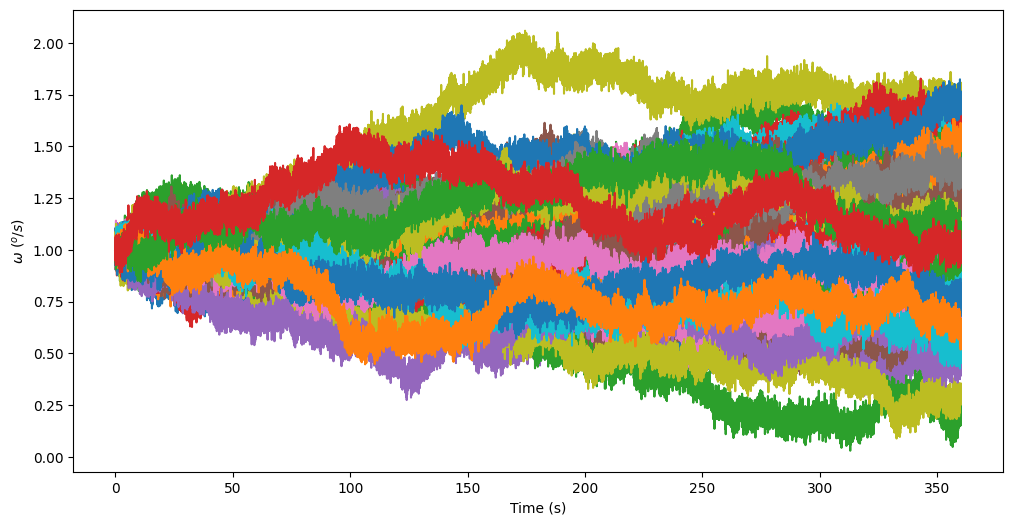

In [24]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6+3])
    plt.plot(time, meas_hist[:,j*6+4])
    plt.plot(time, meas_hist[:,j*6+5])
plt.ylabel("$\omega$ ($^o/s$)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

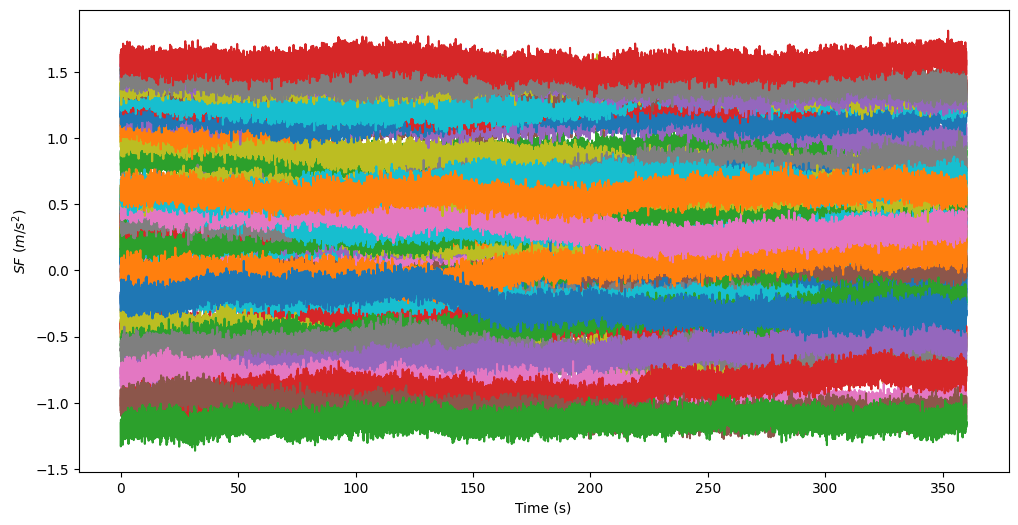

In [25]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6])
    plt.plot(time, meas_hist[:,j*6+1])
    plt.plot(time, meas_hist[:,j*6+2])
plt.ylabel("$SF$ ($m/s^2$)")
plt.xlabel("Time (s)")

IMU 1 SF hat: quantization    0.00000923906673
white           0.00470048691454
flicker         0.00000000000000
walk            0.00035115675154
ramp            0.00012288008532
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00467897374902
flicker         0.00203999769009
walk            0.00000000000000
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00467408514541
flicker         0.00051983431236
walk            0.00060634601875
ramp            0.00004431858410
Name: 0, dtype: float64
IMU 2 SF hat: quantization    0.00003650888333
white           0.00469363483619
flicker         0.00078093851130
walk            0.00048050064734
ramp            0.00001648752654
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00472988310116
flicker         0.00000000000000
walk            0.00064816287630
ramp            0.00009320102682
Name: 0, dtype: float64, quantization    0.00005

(array([1.e-14, 1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00,
        1.e+02]),
 [Text(0, 1e-14, '$\\mathdefault{10^{-14}}$'),
  Text(0, 1e-12, '$\\mathdefault{10^{-12}}$'),
  Text(0, 1e-10, '$\\mathdefault{10^{-10}}$'),
  Text(0, 1e-08, '$\\mathdefault{10^{-8}}$'),
  Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$')])

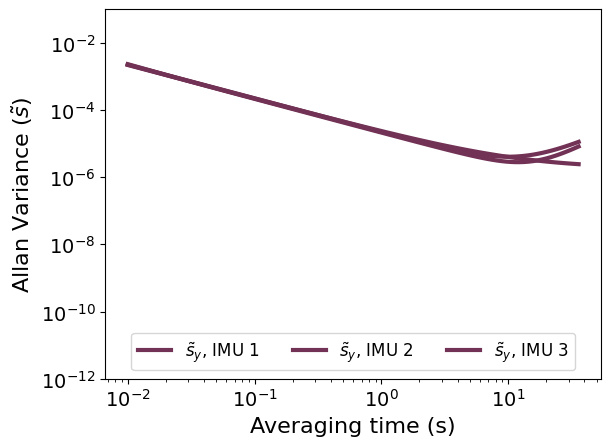

In [41]:
# individual IMUs, omega hat
fig, ax = plt.subplots()
for j in range(3):
    tau_wx, avar_wx = allan_variance.compute_avar(meas_hist[:,j*6], dt)
    tau_wy, avar_wy = allan_variance.compute_avar(meas_hist[:,j*6+1], dt)
    tau_wz, avar_wz = allan_variance.compute_avar(meas_hist[:,j*6+2], dt)
    params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
    params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
    params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
    print(f"IMU {j+1} SF hat: {params_wx}, {params_wy}, {params_wz}")

    # Estimated
    # plt.loglog(tau_wx, avar_pred_wx, '-', label="$\\tilde{s}_x$"+f", IMU {j+1}", linewidth=3, color = "#0060B0")
    plt.loglog(tau_wy, avar_pred_wy, '-', label="$\\tilde{s}_y$"+f", IMU {j+1}", linewidth=3, color = "#723255")
    # plt.loglog(tau_wz, avar_pred_wz, '-', label="$\\tilde{s}_z$"+f", IMU {j+1}", linewidth=3, color = "#EC9F06")

ax.set_ylim([1e-12, 1e-1])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, loc='lower center')
plt.xlabel("Averaging time (s)", fontsize=16)
plt.ylabel("Allan Variance ($\\tilde{s}$)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

IMU 1 omega hat: quantization    0.00003909386808
white           0.00330376338252
flicker         0.00000000000000
walk            0.01862446534779
ramp            0.00244851222564
Name: 0, dtype: float64, quantization    0.00007284992942
white           0.00316253675756
flicker         0.00000000000000
walk            0.02058971074529
ramp            0.00114453291985
Name: 0, dtype: float64, quantization    0.00009496339316
white           0.00301303864913
flicker         0.00564829957180
walk            0.01619064781989
ramp            0.00221299057381
Name: 0, dtype: float64/n
IMU 2 omega hat: quantization    0.00013704185251
white           0.00259847441807
flicker         0.00943511282185
walk            0.01156111300027
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00004018460463
white           0.00323634723735
flicker         0.00396149122755
walk            0.01629402053397
ramp            0.00189949579694
Name: 0, dtype: float64, quantization   

(array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
 [Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$')])

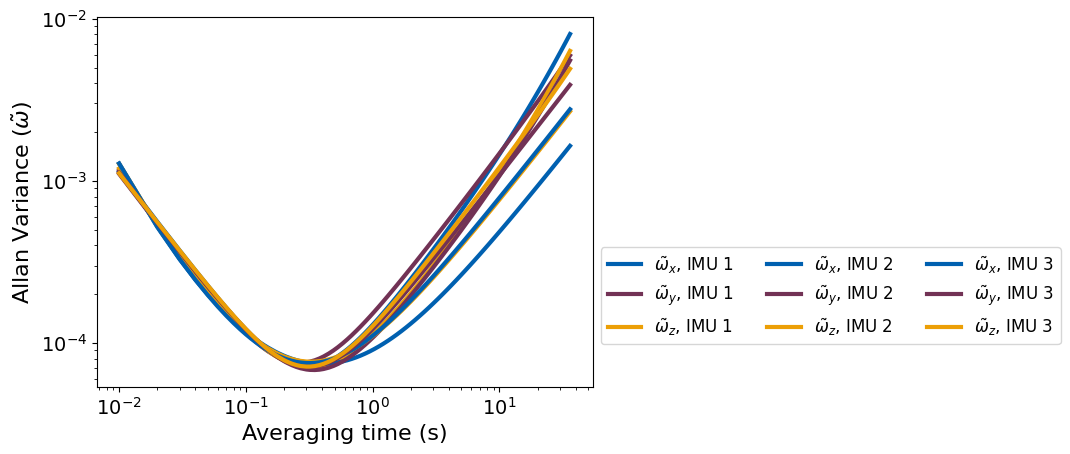

In [27]:
# individual IMUs, Omega hat
fig, ax = plt.subplots()
for j in range(3):
    tau_fx, avar_fx = allan_variance.compute_avar(meas_hist[:,j*6+3], dt)
    tau_fy, avar_fy = allan_variance.compute_avar(meas_hist[:,j*6+4], dt)
    tau_fz, avar_fz = allan_variance.compute_avar(meas_hist[:,j*6+5], dt)
    params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
    params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
    params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
    print(f"IMU {j+1} omega hat: {params_fx}, {params_fy}, {params_fz}/n")

    # Estimated
    plt.loglog(tau_fx, avar_pred_fx, '-', label="$\\tilde{\omega}_x$"+f", IMU {j+1}", linewidth=3, color = "#0060B0")
    plt.loglog(tau_fy, avar_pred_fy, '-', label="$\\tilde{\omega}_y$"+f", IMU {j+1}", linewidth=3, color = "#723255")
    plt.loglog(tau_fz, avar_pred_fz, '-', label="$\\tilde{\omega}_z$"+f", IMU {j+1}", linewidth=3, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(1, 0.4))
plt.xlabel("Averaging time (s)", fontsize=16)
plt.ylabel("Allan Variance ($\\tilde{\omega}$)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim([1e-8, 1e-1])